In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_wine, load_iris, load_digits, make_classification
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, RocCurveDisplay
from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings("ignore")

In [10]:
def get_datasets():
    datasets = []
    # 1. Breast cancer
    data = load_breast_cancer()
    datasets.append(("Breast cancer", data.data, data.target))
    # 2. Wine
    data = load_wine()
    datasets.append(("Wine", data.data, data.target))
    # 3. Iris
    data = load_iris()
    datasets.append(("Iris", data.data, data.target))
    # 4. Digits
    digits = load_digits(n_class=2) 
    datasets.append(("Digits (Binary)", digits.data, digits.target))
    # 5. Sintético
    X, y = make_classification(n_samples=500, n_features=20, n_informative=15, random_state=42)
    datasets.append(("Synthetic", X, y))
    return datasets

# Configuración
knn = KNeighborsClassifier()
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Parámetros
param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh'], 'learning_rate_init': [0.001]}
param_grid_ae = {'activation': ['relu', 'tanh'], 'max_iter': [300]}

results_list = []
roc_data = {} 

datasets_list = get_datasets()
print(f"Iniciando estudio en {len(datasets_list)} datasets...")

for name, X, y in datasets_list:
    print(f"Procesando: {name} {X.shape}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Preparamos ROC solo para breast cancer
    save_roc = (name == "Breast cancer")
    if save_roc:
        roc_data['y_true'] = []
        roc_data['probas'] = {'Original-MLP': [], 'PCA-MLP': [], 'AE-MLP': []}
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_idx = 0
    
    for train_ix, test_ix in cv.split(X_scaled, y):
        fold_idx += 1
        X_train, X_test = X_scaled[train_ix], X_scaled[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        if save_roc: roc_data['y_true'].append(y_test)

        # kNN
        g_knn = GridSearchCV(knn, param_grid_knn, cv=3, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Original', 'Model': 'kNN', 'Accuracy': g_knn.score(X_test, y_test)})
        
        # MLP
        g_mlp = GridSearchCV(mlp, param_grid_mlp, cv=3, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
        acc = g_mlp.score(X_test, y_test)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Original', 'Model': 'MLP', 'Accuracy': acc})
        
        if save_roc: roc_data['probas']['Original-MLP'].append(g_mlp.predict_proba(X_test))

        # --- 2. PCA ---
        pca = PCA(n_components=0.60, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # kNN + PCA
        g_knn.fit(X_train_pca, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'PCA', 'Model': 'kNN', 'Accuracy': g_knn.score(X_test_pca, y_test)})
        
        # MLP + PCA
        g_mlp.fit(X_train_pca, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'PCA', 'Model': 'MLP', 'Accuracy': g_mlp.score(X_test_pca, y_test)})
        
        if save_roc: roc_data['probas']['PCA-MLP'].append(g_mlp.predict_proba(X_test_pca))

        # --- 3. AUTOENCODER ---
        n_hidden = max(1, X_train.shape[1] // 2)
        ae = MLPRegressor(hidden_layer_sizes=(n_hidden,), random_state=42)
        g_ae = GridSearchCV(ae, param_grid_ae, cv=3, scoring='neg_mean_squared_error', n_jobs=-1).fit(X_train, X_train)
        best_ae = g_ae.best_estimator_
        
        def get_latent(model, data):
            W, b = model.coefs_[0], model.intercepts_[0]
            z = np.dot(data, W) + b
            return np.maximum(0, z) if model.activation == 'relu' else np.tanh(z)

        X_train_ae = get_latent(best_ae, X_train)
        X_test_ae = get_latent(best_ae, X_test)
        
        # kNN + AE
        g_knn.fit(X_train_ae, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Autoencoder', 'Model': 'kNN', 'Accuracy': g_knn.score(X_test_ae, y_test)})

        # MLP + AE
        g_mlp.fit(X_train_ae, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Autoencoder', 'Model': 'MLP', 'Accuracy': g_mlp.score(X_test_ae, y_test)})
        
        if save_roc: roc_data['probas']['AE-MLP'].append(g_mlp.predict_proba(X_test_ae))

df_results = pd.DataFrame(results_list)
print("Entrenamiento completado correctamente.")

Iniciando estudio en 5 datasets...
Procesando: Breast cancer (569, 30)
Procesando: Wine (178, 13)
Procesando: Iris (150, 4)
Procesando: Digits (Binary) (360, 64)
Procesando: Synthetic (500, 20)
Entrenamiento completado correctamente.


In [11]:
# Configuración de modelos
knn = KNeighborsClassifier()
mlp = MLPClassifier(max_iter=1000, random_state=42)

# Conjuntos de hiperparámetros
param_grid_knn = {'n_neighbors': [3, 5, 7]}
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh'], 'learning_rate_init': [0.001]}
param_grid_ae = {'activation': ['relu', 'tanh'], 'max_iter': [300]}

results_list = []
roc_data = {} # Para guardar datos de curvas ROC del breast cancer

datasets_list = get_datasets()
print(f"Iniciando estudio científico en {len(datasets_list)} datasets...")

for name, X, y in datasets_list:
    print(f"  ➜ Procesando: {name} {X.shape}")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Solo guardaremos ROC del dataset 'Breast Cancer' como caso de estudio principal
    save_roc = (name == "Breast cancer")
    if save_roc:
        roc_data['y_true'] = []
        roc_data['probas'] = {'Original-MLP': [], 'PCA-MLP': [], 'AE-MLP': []}
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    fold_idx = 0
    
    for train_ix, test_ix in cv.split(X_scaled, y):
        fold_idx += 1
        X_train, X_test = X_scaled[train_ix], X_scaled[test_ix]
        y_train, y_test = y[train_ix], y[test_ix]
        
        if save_roc: roc_data['y_true'].append(y_test)

        # kNN
        g_knn = GridSearchCV(knn, param_grid_knn, cv=3).fit(X_train, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Original', 'Model': 'kNN', 'Accuracy': g_knn.score(X_test, y_test)})
        
        # MLP
        g_mlp = GridSearchCV(mlp, param_grid_mlp, cv=3).fit(X_train, y_train)
        acc = g_mlp.score(X_test, y_test)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Original', 'Model': 'MLP', 'Accuracy': acc})
        
        if save_roc: roc_data['probas']['Original-MLP'].append(g_mlp.predict_proba(X_test))

        # B) PCA (60% Varianza)
        pca = PCA(n_components=0.60, random_state=42)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        # kNN + PCA
        g_knn.fit(X_train_pca, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'PCA', 'Model': 'kNN', 'Accuracy': g_knn.score(X_test_pca, y_test)})
        
        # MLP + PCA
        g_mlp.fit(X_train_pca, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'PCA', 'Model': 'MLP', 'Accuracy': g_mlp.score(X_test_pca, y_test)})
        
        if save_roc: roc_data['probas']['PCA-MLP'].append(g_mlp.predict_proba(X_test_pca))

        # C) AUTOENCODER (50% Features)
        n_hidden = max(1, X_train.shape[1] // 2)
        ae = MLPRegressor(hidden_layer_sizes=(n_hidden,), random_state=42)
        g_ae = GridSearchCV(ae, param_grid_ae, cv=3, scoring='neg_mean_squared_error').fit(X_train, X_train)
        best_ae = g_ae.best_estimator_
        
        # Función de extracción manual
        def get_latent(model, data):
            W, b = model.coefs_[0], model.intercepts_[0]
            z = np.dot(data, W) + b
            return np.maximum(0, z) if model.activation == 'relu' else np.tanh(z)

        X_train_ae = get_latent(best_ae, X_train)
        X_test_ae = get_latent(best_ae, X_test)
        
        # kNN + AE
        g_knn.fit(X_train_ae, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Autoencoder', 'Model': 'kNN', 'Accuracy': g_knn.score(X_test_ae, y_test)})

        # MLP + AE
        g_mlp.fit(X_train_ae, y_train)
        results_list.append({'Dataset': name, 'Fold': fold_idx, 'Type': 'Autoencoder', 'Model': 'MLP', 'Accuracy': g_mlp.score(X_test_ae, y_test)})
        
        if save_roc: roc_data['probas']['AE-MLP'].append(g_mlp.predict_proba(X_test_ae))

df_results = pd.DataFrame(results_list)
print("Entrenamiento completado exitosamente. Datos listos.")

Iniciando estudio científico en 5 datasets...
  ➜ Procesando: Breast cancer (569, 30)
  ➜ Procesando: Wine (178, 13)
  ➜ Procesando: Iris (150, 4)
  ➜ Procesando: Digits (Binary) (360, 64)
  ➜ Procesando: Synthetic (500, 20)
Entrenamiento completado exitosamente. Datos listos.


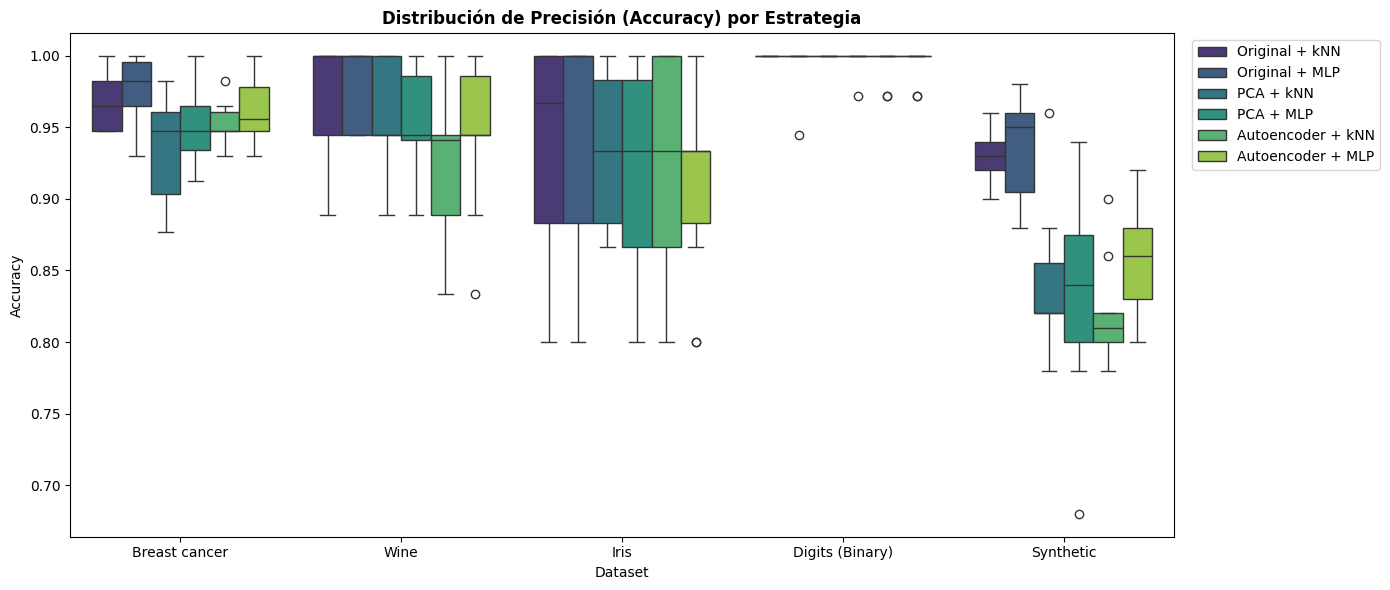

📊 Generando Heatmap Estadístico...


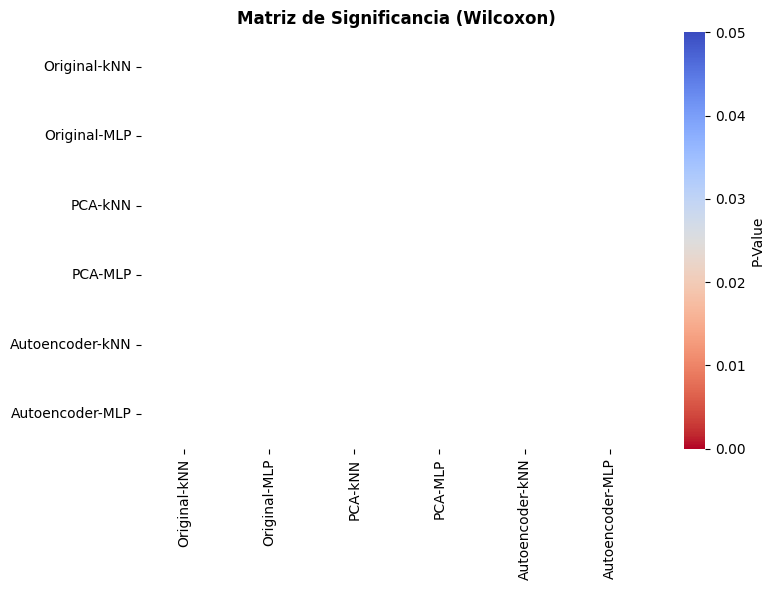

📈 Generando Curvas ROC...


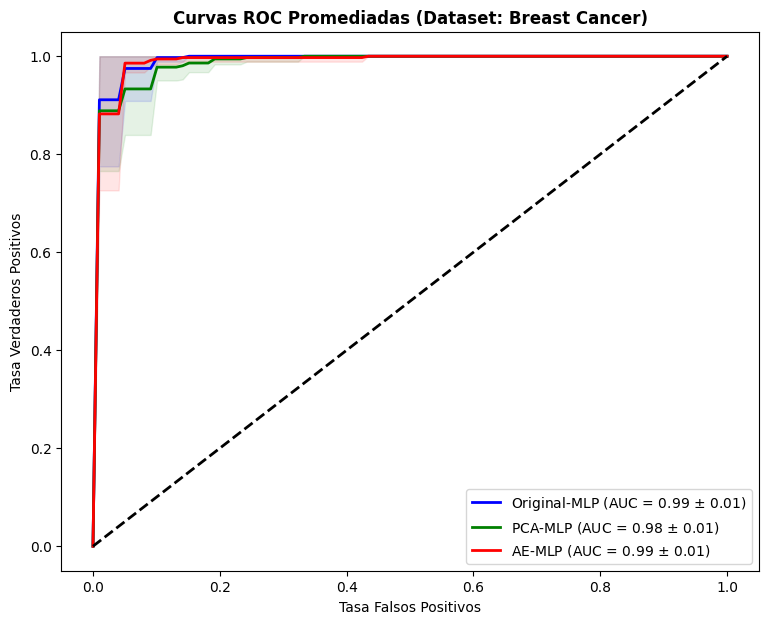

In [12]:
def plot_all_results(df, roc_data):
    # --- 1. BOXPLOT GLOBAL ---
    if not df.empty:
        plt.figure(figsize=(14, 6))
        df['Config'] = df['Type'] + " + " + df['Model']
        sns.boxplot(x='Dataset', y='Accuracy', hue='Config', data=df, palette='viridis')
        plt.title('Distribución de Precisión (Accuracy) por Estrategia', fontweight='bold')
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig('accuracy_boxplot.png', dpi=300)
        plt.show()
    else:
        print("⚠️ El DataFrame de resultados está vacío. Revisa la Celda 3.")

    # --- 2. HEATMAP DE WILCOXON ---
    if not df.empty:
        print("📊 Generando Heatmap Estadístico...")
        df['Strategy'] = df['Type'] + "-" + df['Model']
        strategies = df['Strategy'].unique()
        p_vals = np.zeros((len(strategies), len(strategies)))
        
        for i, s1 in enumerate(strategies):
            for j, s2 in enumerate(strategies):
                if i >= j: 
                    p_vals[i,j] = np.nan
                    continue
                d1 = df[df['Strategy'] == s1].groupby(['Dataset','Fold'])['Accuracy'].mean()
                d2 = df[df['Strategy'] == s2].groupby(['Dataset','Fold'])['Accuracy'].mean()
                try:
                    stat, p = wilcoxon(d1, d2)
                    p_vals[i,j] = p
                    p_vals[j,i] = p
                except: p_vals[i,j] = 1.0
                
        plt.figure(figsize=(8, 6))
        mask = np.triu(np.ones_like(p_vals, dtype=bool))
        sns.heatmap(p_vals, xticklabels=strategies, yticklabels=strategies, annot=True, fmt=".3f", 
                    cmap="coolwarm_r", mask=mask, vmin=0, vmax=0.05, cbar_kws={'label': 'P-Value'})
        plt.title('Matriz de Significancia (Wilcoxon)', fontweight='bold')
        plt.tight_layout()
        plt.savefig('wilcoxon_heatmap.png', dpi=300)
        plt.show()

    # --- 3. CURVA ROC (Aquí estaba tu error) ---
    # Comprobamos si 'probas' existe en roc_data antes de acceder
    if roc_data and 'probas' in roc_data and len(roc_data['probas']['Original-MLP']) > 0:
        print("📈 Generando Curvas ROC...")
        plt.figure(figsize=(9, 7))
        mean_fpr = np.linspace(0, 1, 100)
        colors = {'Original-MLP': 'blue', 'PCA-MLP': 'green', 'AE-MLP': 'red'}
        
        for label, probas in roc_data['probas'].items():
            tprs = []
            aucs = []
            for i, (yt, yp) in enumerate(zip(roc_data['y_true'], probas)):
                preds = yp[:, 1] if yp.ndim > 1 else yp
                fpr, tpr, _ = roc_curve(yt, preds)
                interp_tpr = np.interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(auc(fpr, tpr))
                
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            std_auc = np.std(aucs)
            
            plt.plot(mean_fpr, mean_tpr, color=colors[label], lw=2,
                     label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (label, mean_auc, std_auc))
            
            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[label], alpha=.1)
            
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('Tasa Falsos Positivos')
        plt.ylabel('Tasa Verdaderos Positivos')
        plt.title('Curvas ROC Promediadas (Dataset: Breast Cancer)', fontweight='bold')
        plt.legend(loc="lower right")
        plt.savefig('scientific_roc.png', dpi=300)
        plt.show()

# Ejecutar todo de forma segura
plot_all_results(df_results, roc_data)

In [13]:
# Tabla resumen
summary = df_results.groupby(['Dataset', 'Type', 'Model'])['Accuracy'].mean().unstack()
print("=== TABLA DE RESULTADOS MEDIOS (ACCURACY) ===")
print(summary)

# Test rápido de Wilcoxon para conclusiones
print("\n=== CONCLUSIONES ESTADÍSTICAS RÁPIDAS (kNN vs MLP Global) ===")
acc_knn = df_results[df_results['Model'] == 'kNN']['Accuracy']
acc_mlp = df_results[df_results['Model'] == 'MLP']['Accuracy']
s, p = wilcoxon(acc_knn, acc_mlp)
print(f"kNN vs MLP -> p-value: {p:.5e} ({'Significativo' if p<0.05 else 'No sig.'})")

=== TABLA DE RESULTADOS MEDIOS (ACCURACY) ===
Model                             MLP       kNN
Dataset         Type                           
Breast cancer   Autoencoder  0.963158  0.950846
                Original     0.977193  0.966635
                PCA          0.950877  0.935056
Digits (Binary) Autoencoder  0.994444  0.994444
                Original     0.994444  1.000000
                PCA          0.997222  1.000000
Iris            Autoencoder  0.913333  0.926667
                Original     0.946667  0.940000
                PCA          0.920000  0.933333
Synthetic       Autoencoder  0.860000  0.818000
                Original     0.934000  0.932000
                PCA          0.832000  0.842000
Wine            Autoencoder  0.944444  0.921569
                Original     0.977778  0.966667
                PCA          0.949346  0.960784

=== CONCLUSIONES ESTADÍSTICAS RÁPIDAS (kNN vs MLP Global) ===
kNN vs MLP -> p-value: 1.37667e-01 (No sig.)


 Entrenando Autoencoder para visualización...


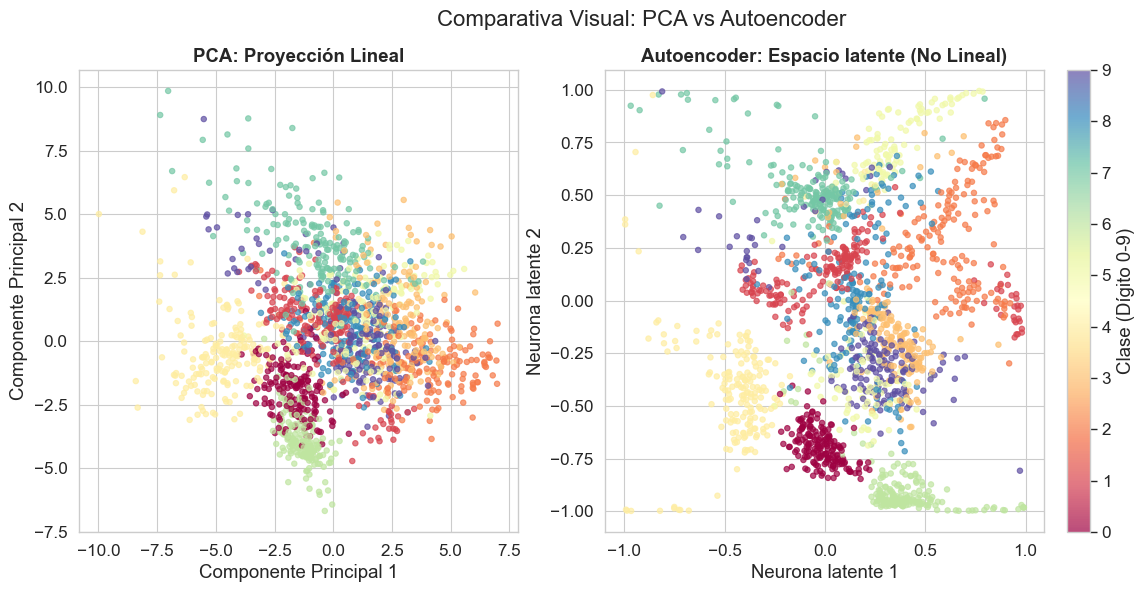

In [14]:
sns.set_context("paper", font_scale=1.4)
sns.set_style("whitegrid")

def force_generate_latent_image():    
    # 1. Cargar datos Digits (ideal para visualizar clusters)
    digits = load_digits()
    X, y = digits.data, digits.target
    X_scaled = StandardScaler().fit_transform(X)
    
    # 2. Calcular PCA (2 componentes)
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # 3. Calcular Autoencoder (Forzando cuello de botella de 2 neuronas)
    # Arquitectura: Entrada -> 32 -> [2] -> 32 -> Salida
    print(" Entrenando Autoencoder para visualización...")
    ae = MLPRegressor(hidden_layer_sizes=(32, 2, 32), 
                      activation='tanh', 
                      max_iter=1000, 
                      random_state=42)
    ae.fit(X_scaled, X_scaled)
    
    # Extraer manualmente los valores de las 2 neuronas centrales
    W1, b1 = ae.coefs_[0], ae.intercepts_[0]
    z1 = np.tanh(np.dot(X_scaled, W1) + b1)
    
    W2, b2 = ae.coefs_[1], ae.intercepts_[1]
    z_bottleneck = np.tanh(np.dot(z1, W2) + b2)
    
    # 4. Crear el Gráfico
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot PCA
    sc1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Spectral', alpha=0.7, s=15)
    axes[0].set_title('PCA: Proyección Lineal', fontweight='bold')
    axes[0].set_xlabel('Componente Principal 1')
    axes[0].set_ylabel('Componente Principal 2')
    
    # Plot autoencoder
    sc2 = axes[1].scatter(z_bottleneck[:, 0], z_bottleneck[:, 1], c=y, cmap='Spectral', alpha=0.7, s=15)
    axes[1].set_title('Autoencoder: Espacio latente (No Lineal)', fontweight='bold')
    axes[1].set_xlabel('Neurona latente 1')
    axes[1].set_ylabel('Neurona latente 2')
    
    # Leyenda de color compartida
    cbar = plt.colorbar(sc1, ax=axes.ravel().tolist(), pad=0.02)
    cbar.set_label('Clase (Dígito 0-9)')
    
    plt.suptitle('Comparativa Visual: PCA vs Autoencoder', fontsize=16, y=0.98)
    
    # 5. GUARDADO EXPLÍCITO
    plt.savefig('latent_space.png', dpi=300, bbox_inches='tight')
    plt.show()

# Ejecutar la función
force_generate_latent_image()